<a href="https://colab.research.google.com/github/SetuKaswan/zeotap/blob/main/Setu_Kaswan_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing the data

In [36]:
import pandas as pd

In [37]:
customers_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Customers.csv'
products_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Products.csv'
transactions_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Transactions.csv'

In [38]:
from urllib.request import urlretrieve
urlretrieve(customers_url, 'customers.csv')
urlretrieve(products_url, 'products.csv')
urlretrieve(transactions_url, 'transactions.csv')

('transactions.csv', <http.client.HTTPMessage at 0x7d152e31bc90>)

In [39]:
customers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')

In [40]:
customers_df.head()
products_df.head()
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [42]:
# Merge the datasets to combine customer and transaction information
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")
merged_df = pd.merge(merged_df, products_df, on="ProductID", how="inner")

# Feature Engineering: Create summary features for each customer
customer_features = merged_df.groupby('CustomerID').agg(
    transaction_count=('TransactionID', 'count'),
    total_spend=('TotalValue', 'sum'),
    total_items=('Quantity', 'sum'),
    avg_order_value=('TotalValue', 'mean')
).reset_index()

# Display the customer features
customer_features.head()

,CustomerID,transaction_count,total_spend,total_items,avg_order_value
0,C0001,5,3354.52,12,670.904
1,C0002,4,1862.74,10,465.685
2,C0003,4,2725.38,14,681.345
3,C0004,8,5354.88,23,669.360
4,C0005,3,2034.24,7,678.080


In [43]:
from sklearn.preprocessing import StandardScaler

# One-hot encode the 'Region' column
customer_features = pd.merge(customer_features, customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Drop the CustomerID as we don't want it to be used in clustering
customer_features_cleaned = customer_features.drop(columns=['CustomerID'])

# Standardize the data (scale features to have mean=0 and variance=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features_cleaned)

# Display the scaled features
scaled_features[:5]

array([[-0.01145819, -0.06170143, -0.12203296, -0.07026341, -0.57928445,
        -0.54831888,  1.54041597],
       [-0.46749414, -0.87774353, -0.44800021, -0.93493297, -0.57928445,
        -0.54831888, -0.6491753 ],
       [-0.46749414, -0.40585722,  0.20393428, -0.02627131, -0.57928445,
        -0.54831888,  1.54041597],
       [ 1.35664965,  1.03254704,  1.67078689, -0.0767689 , -0.57928445,
        -0.54831888,  1.54041597],
       [-0.92353008, -0.78392861, -0.93695108, -0.04002806, -0.57928445,
        -0.54831888, -0.6491753 ]])

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Apply KMeans clustering (choosing 5 clusters for now)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.1658215265651921


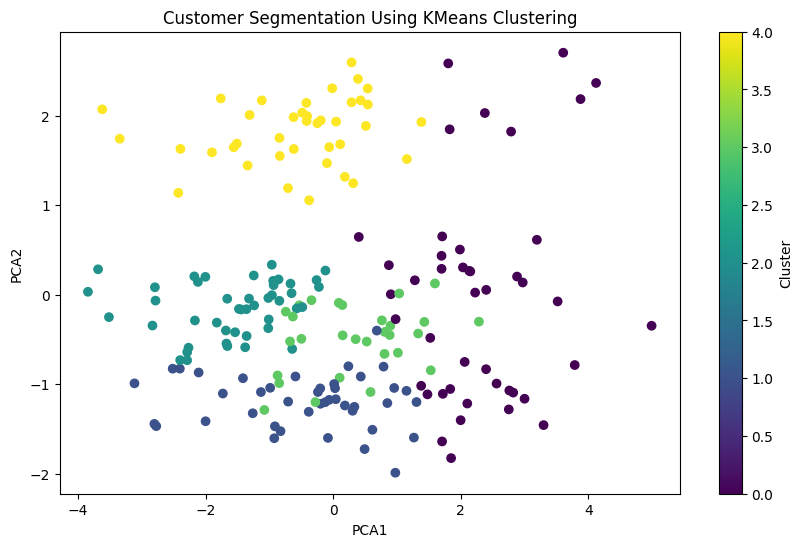

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the customer features
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

# Plot the clusters in 2D
plt.figure(figsize=(10, 6))
plt.scatter(customer_features['PCA1'], customer_features['PCA2'], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segmentation Using KMeans Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()


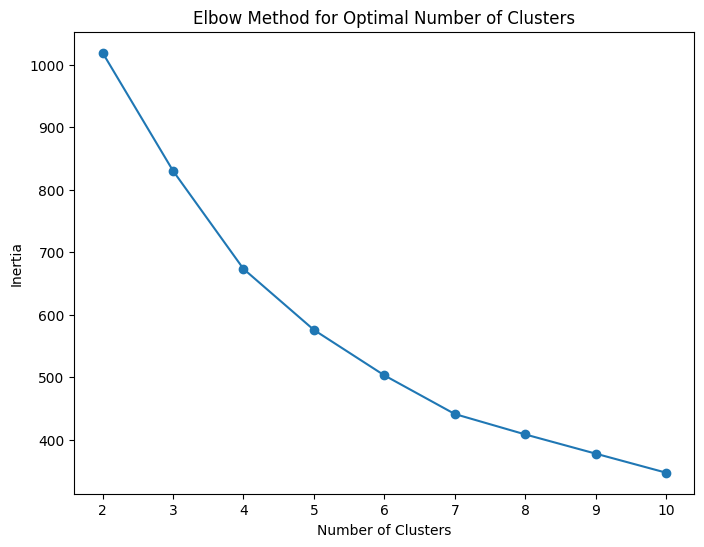

In [46]:
# Elbow method: Trying different values of k to find the optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the inertia to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


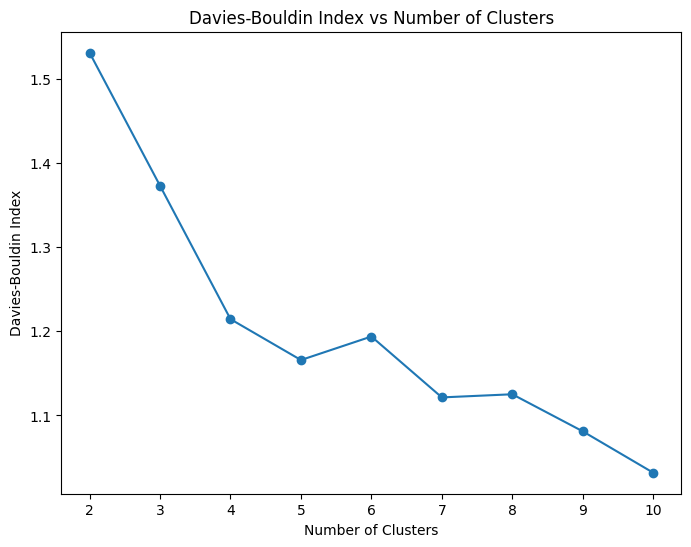

In [48]:
from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin index for different k values
db_indices = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    db_indices.append(davies_bouldin_score(scaled_features, kmeans.labels_))

# Plot Davies-Bouldin index vs. Number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), db_indices, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()